In [2]:
!pip install kaggle

In [3]:
!pip install catboost

     |████████████████████████████████| 67.3MB 78kB/s 


In [6]:
#importing all modules we need
import catboost as cb
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [62]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
data_description.txt: Skipping, found more recently modified local copy (use --force to force download)


In [63]:
#downloading a train data
mydata = pd.read_csv('./train.csv')

In [65]:
#take a look at the train data
mydata.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [66]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [67]:
#separating numeric and categorical features
cat_data = mydata.select_dtypes("object")
num_data = mydata.select_dtypes("number").drop(['Id', 'SalePrice'], axis=1)

In [69]:
#change all "NaN" in categorial data to "None"
cat_data.loc[:].fillna('None', inplace = True)

In [70]:
#change all "NaN" in categorial data to mean
num_data.loc[:].fillna(num_data.mean(), inplace=True)

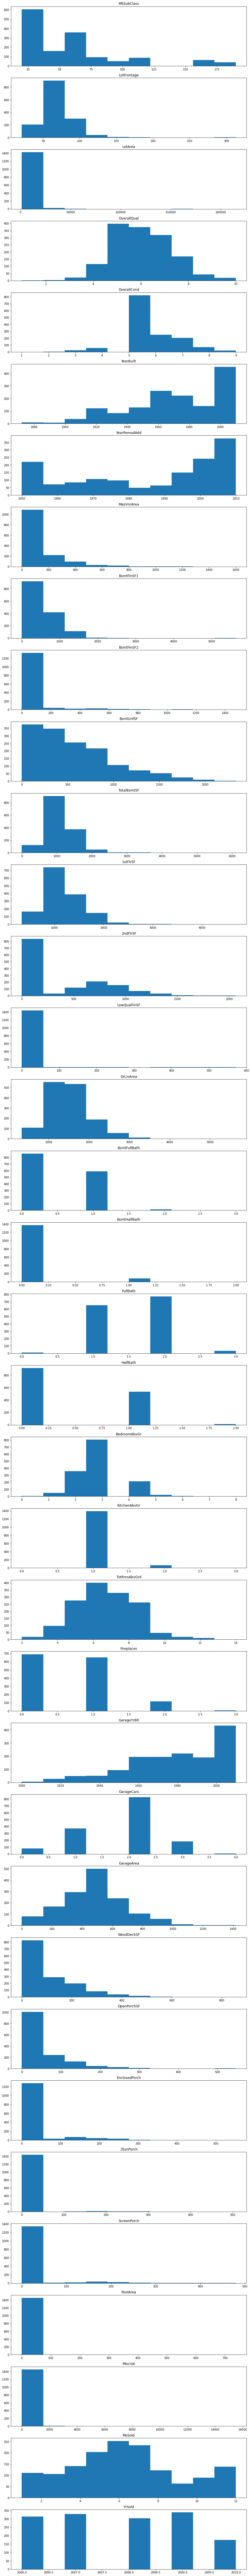

In [71]:
#making histograms of numeric data
plt.figure(figsize=(15,200))
for id, item in enumerate(num_data):
  plt.subplot(cat_data.shape[1], 1, id+1)
  plt.hist(num_data[item])
  plt.title(item)

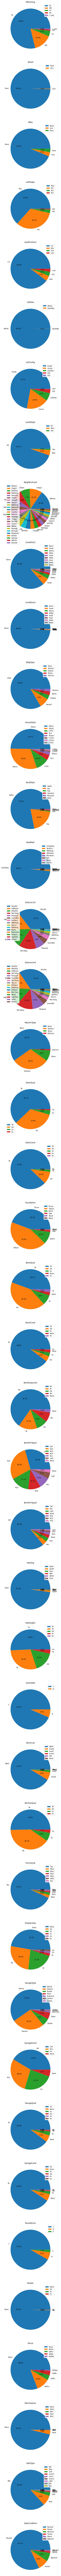

In [72]:
#making pie-plots of categorical data
plt.figure(figsize=(100,300))
for id, item in enumerate(cat_data):
  plt.subplot(cat_data.shape[1], 1, id+1)
  cat_data[item].value_counts().plot(kind='pie', autopct='%1.1f%%', ylabel='' )
  plt.title(item)
  plt.legend()

In [73]:
#normilising numeric data
scaler = StandardScaler()
scaler.fit(num_data)
scaler.transform(num_data)
num_data = pd.DataFrame(scaler.transform(num_data), index=num_data.index, columns=num_data.columns)

In [74]:
#making label set
y = mydata['SalePrice']
X = pd.concat([cat_data, num_data], axis=1)

In [75]:
# catboost doesn't need one-hot encoded categorial data
# so we need to use original categorial data without transformations
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                       train_size=0.8, 
                                                       random_state=42)
cat_features = [cat for cat in range(len(cat_data.columns))] #IDs of cat columns

In [76]:
#Making a catboost model (Regressor)
cat_boost_model = cb.CatBoostRegressor(loss_function='RMSE')

In [80]:
train_dataset = cb.Pool(X_train, y_train, cat_features) 
test_dataset = cb.Pool(X_test, y_test, cat_features)

In [81]:
#Grid-searching best parameters of regressor
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
cat_boost_model.grid_search(grid, train_dataset)

Streaming output truncated to the last 5000 lines.
151:	learn: 21155.0776617	test: 24869.6889753	best: 24869.6889753 (151)	total: 4.82s	remaining: 1.52s
152:	learn: 21059.3273016	test: 24842.2777954	best: 24842.2777954 (152)	total: 4.85s	remaining: 1.49s
153:	learn: 20999.1915902	test: 24826.3243601	best: 24826.3243601 (153)	total: 4.88s	remaining: 1.46s
154:	learn: 20941.1756668	test: 24801.7021125	best: 24801.7021125 (154)	total: 4.91s	remaining: 1.43s
155:	learn: 20876.4123877	test: 24736.8500254	best: 24736.8500254 (155)	total: 4.95s	remaining: 1.4s
156:	learn: 20797.8842930	test: 24704.4756456	best: 24704.4756456 (156)	total: 4.98s	remaining: 1.36s
157:	learn: 20714.7170364	test: 24683.4319039	best: 24683.4319039 (157)	total: 5.01s	remaining: 1.33s
158:	learn: 20668.1944728	test: 24674.4157095	best: 24674.4157095 (158)	total: 5.06s	remaining: 1.3s
159:	learn: 20591.4171271	test: 24665.1263180	best: 24665.1263180 (159)	total: 5.09s	remaining: 1.27s
160:	learn: 20502.2432110	test: 2

{'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49,
             

In [92]:
#scoring model using validation data
pred = cat_boost_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 25650.01
R2: 0.91


Text(0.5, 0, 'CatBoost Feature Importance')

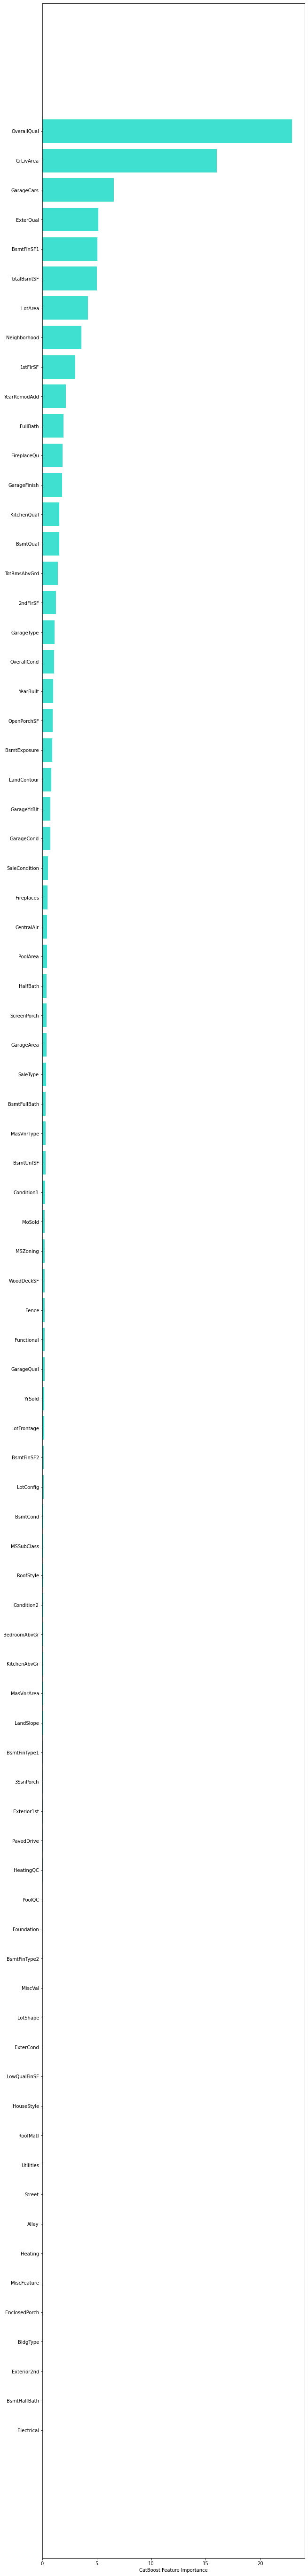

In [93]:
#take a look to the feature importance
sorted_feature_importance = cat_boost_model.feature_importances_.argsort()
plt.figure(figsize=(10,100))
plt.barh(X.columns[sorted_feature_importance], 
       cat_boost_model.feature_importances_[sorted_feature_importance], 
       color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [85]:
#downloading and normalising test data
testdata = pd.read_csv('./test.csv')
test_cat_data = testdata.select_dtypes("object")
test_num_data = testdata.select_dtypes("number").drop(['Id'], axis=1)
test_cat_data.loc[:].fillna('None', inplace = True)
test_num_data.loc[:].fillna(num_data.mean(), inplace=True)
test_scaler = StandardScaler()
test_scaler.fit(test_num_data)
test_num_data = pd.DataFrame(test_scaler.transform(test_num_data), index=test_num_data.index, columns=test_num_data.columns)
test_data_boost = pd.concat([test_cat_data, test_num_data], axis = 1)
test_data_boost.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,RH,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,TA,TA,No,Rec,LwQ,GasA,TA,Y,SBrkr,TA,Typ,None,Attchd,Unf,TA,TA,Y,None,MnPrv,None,WD,Normal,-0.874711,0.684849,0.363929,-0.751101,0.400766,-0.340945,-1.072885,-0.563316,0.063936,0.517537,-0.649392,-0.368484,-0.654561,-0.775254,-0.080483,-1.215588,-0.818068,-0.25816,-1.028720,-0.751040,-1.029543,-0.20391,-0.918335,-0.898055,0.199739,-0.984704,1.185511,0.366678,-0.701628,-0.360738,-0.088827,1.818960,-0.057227,-0.092244,-0.038281,1.713905
1,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,Gd,Typ,None,Attchd,Unf,TA,TA,Y,None,None,Gar2,WD,Normal,-0.874711,0.715852,0.897861,-0.054877,0.400766,-0.439695,-1.214908,0.047057,1.063714,-0.297689,-0.338322,0.639542,0.433298,-0.775254,-0.080483,-0.323539,-0.818068,-0.25816,-1.028720,1.237648,0.175997,-0.20391,-0.255371,-0.898055,0.193007,-0.984704,-0.738518,2.347867,-0.178826,-0.360738,-0.088827,-0.301543,-0.057227,19.730438,-0.038281,1.713905
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Gd,Y,SBrkr,TA,Typ,TA,Attchd,Fin,TA,TA,Y,None,MnPrv,None,WD,Normal,0.061351,0.498831,0.809646,-0.751101,-0.497418,0.844059,0.678742,-0.563316,0.773668,-0.297689,-0.953599,-0.264750,-0.574165,0.891944,-0.080483,0.294508,-0.818068,-0.25816,0.773083,1.237648,0.175997,-0.20391,-0.255371,0.647066,0.280523,0.302646,0.043982,0.930495,-0.207871,-0.360738,-0.088827,-0.301543,-0.057227,-0.092244,-1.140614,1.713905
3,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,Fin,TA,TA,Y,None,None,None,WD,Normal,0.061351,0.622843,0.032064,-0.054877,0.400766,0.876976,0.678742,-0.450284,0.358376,-0.297689,-0.525879,-0.269260,-0.579190,0.837243,-0.080483,0.243004,-0.818068,-0.25816,0.773083,1.237648,0.175997,-0.20391,0.407593,0.647066,0.282767,0.302646,-0.011253,2.089451,-0.178826,-0.360738,-0.088827,-0.301543,-0.057227,-0.092244,-0.038281,1.713905
4,RL,Pave,None,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,Gable,CompShg,HdBoard,HdBoard,None,Gd,TA,PConc,Gd,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,None,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal,1.465443,-0.462261,-0.971808,1.337571,-0.497418,0.679475,0.394694,-0.563316,-0.386513,-0.297689,1.059203,0.529042,0.310192,-0.775254,-0.080483,-0.424487,-0.818068,-0.25816,0.773083,-0.751040,-1.029543,-0.20391,-0.918335,-0.898055,0.269303,0.302646,0.154452,-0.729632,0.489198,-0.360738,-0.088827,2.243060,-0.057227,-0.092244,-1.875504,1.713905


In [86]:
#downloading example of submission file
submission = pd.read_csv('sample_submission.csv')

In [94]:
submission.head()

,Id,SalePrice
0,1461,121462.560425
1,1462,154630.692655
2,1463,190882.146746
3,1464,190053.059221
4,1465,189941.620168


In [89]:
#,making our own submission file
submission['SalePrice'] = cat_boost_model.predict(test_data_boost)
submission.to_csv('./my_submission_catboost.csv', index=False)

In [90]:
submission
#kaggle score of this submission is 0.13376

,Id,SalePrice
0,1461,121462.560425
1,1462,154630.692655
2,1463,190882.146746
3,1464,190053.059221
4,1465,189941.620168
...,...,...
1454,2915,91694.031308
1455,2916,89743.961613
1456,2917,172894.653094
1457,2918,123803.351263
